# Imports

In [2]:
%load_ext autoreload
%autoreload all
import os
import pandas as pd
import numpy as np
import anndata
import time
import json
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import matplotlib.colors as plt_colors
from Utils.Utils import broad_division_color_map, htr_cmap_rgb, cluster_groups_cmap, htr_cmap, percentage_non_zero
from scipy.signal import find_peaks
from Utils.Settings import download_base, manifest

The prerequisite for running this notebook is that the data have been downloaded to local directory maintaining the organization from the manifest.json. **Change the download_base variable to where you have downloaded the data in your system.**

In [3]:
datasets = ['Zhuang-ABCA-1','Zhuang-ABCA-2','Zhuang-ABCA-3','Zhuang-ABCA-4']

metadata = {}
for d in datasets :
    metadata[d] = manifest['file_listing'][d]['metadata']

# Load data


In [4]:
cell = {}

for d in datasets :
    
    rpath = metadata[d]['cell_metadata']['files']['csv']['relative_path']
    file = os.path.join( download_base, rpath)
    cell[d] = pd.read_csv(file, dtype={"cell_label":str})
    cell[d].set_index('cell_label',inplace=True)
    
    sdf = cell[d].groupby('brain_section_label')
    
    print(d,":","Number of cells = ", len(cell[d]), ", ", "Number of sections =", len(sdf))

Zhuang-ABCA-1 : Number of cells =  2846908 ,  Number of sections = 147
Zhuang-ABCA-2 : Number of cells =  1227408 ,  Number of sections = 66
Zhuang-ABCA-3 : Number of cells =  1585843 ,  Number of sections = 23
Zhuang-ABCA-4 : Number of cells =  162578 ,  Number of sections = 3


### Cluster annotation

Read in the pivot table from the "cluster annotation tutorial" to associate each cell with terms at each cell type classification level and the corresponding color.

In [5]:
taxonomy_metadata = manifest['file_listing']['WMB-taxonomy']['metadata']

rpath = taxonomy_metadata['cluster_to_cluster_annotation_membership_pivoted']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cluster_details = pd.read_csv(file,keep_default_na=False)
cluster_details.set_index('cluster_alias', inplace=True)

rpath = taxonomy_metadata['cluster_to_cluster_annotation_membership_color']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cluster_colors = pd.read_csv(file)
cluster_colors.set_index('cluster_alias', inplace=True)

In [6]:
cell_extended = {}

for d in datasets :
    cell_extended[d] = cell[d].join(cluster_details,on='cluster_alias')
    cell_extended[d] = cell_extended[d].join(cluster_colors,on='cluster_alias')

For convenience, we can cache this view for later reuse.

### Gene panel

All 4 datasets shares the same 1122 gene panel selected to enable faciliate the mapping to transcriptomically defined cell types taxonomies. Each gene is uniquely identifier by an Ensembl ID. It is best practice to gene identifier to for tracking and data interchange as gene symbols are not unique and can change over time.

Each row of the gene dataframe has Ensembl gene identifier, a gene symbol and name.

In [8]:
rpath = metadata[datasets[0]]['gene']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
gene = pd.read_csv(file)
gene.set_index('gene_identifier',inplace=True)
print("Number of genes = ", len(gene))


Number of genes =  1122


,gene_symbol,name,mapped_ncbi_identifier
gene_identifier,,,
ENSMUSG00000024798,Htr7,5-hydroxytryptamine (serotonin) receptor 7,NCBIGene:15566
ENSMUSG00000042385,Gzmk,granzyme K,NCBIGene:14945
ENSMUSG00000036198,Arhgap36,Rho GTPase activating protein 36,NCBIGene:75404
ENSMUSG00000028780,Sema3c,"sema domain, immunoglobulin domain (Ig), short...",NCBIGene:20348
ENSMUSG00000015843,Rxrg,retinoid X receptor gamma,NCBIGene:20183


In [9]:
expression_matrices = {}

for d in datasets :
    expression_matrices[d] = manifest['file_listing'][d]['expression_matrices']

In [10]:
htrgenes =  gene.gene_symbol[ gene.gene_symbol.str.contains("Htr")].values
htrgenes = np.sort(htrgenes)
pred = [x in htrgenes for x in gene.gene_symbol]
gene_filtered = gene[pred]
gene_filtered

,gene_symbol,name,mapped_ncbi_identifier
gene_identifier,,,
ENSMUSG00000024798,Htr7,5-hydroxytryptamine (serotonin) receptor 7,NCBIGene:15566
ENSMUSG00000050783,Htr1f,5-hydroxytryptamine (serotonin) receptor 1F,NCBIGene:15557
ENSMUSG00000070687,Htr1d,5-hydroxytryptamine (serotonin) receptor 1D,NCBIGene:15552
ENSMUSG00000026322,Htr4,5 hydroxytryptamine (serotonin) receptor 4,NCBIGene:15562
ENSMUSG00000049511,Htr1b,5-hydroxytryptamine (serotonin) receptor 1B,NCBIGene:15551
ENSMUSG00000034997,Htr2a,5-hydroxytryptamine (serotonin) receptor 2A,NCBIGene:15558
ENSMUSG00000021721,Htr1a,5-hydroxytryptamine (serotonin) receptor 1A,NCBIGene:15550
ENSMUSG00000041380,Htr2c,5-hydroxytryptamine (serotonin) receptor 2C,NCBIGene:15560
ENSMUSG00000032269,Htr3a,5-hydroxytryptamine (serotonin) receptor 3A,NCBIGene:15561


In [11]:
cell_expression = {}
cell_expression_bool = {}

for d in datasets :
    
    expression_matrices[d]
    rpath = expression_matrices[d][d]['log2']['files']['h5ad']['relative_path']
    file = os.path.join( download_base, rpath)
    
    adata = anndata.read_h5ad(file,backed='r')
    
    start = time.process_time()
    gdata = adata[:,gene_filtered.index].to_df()
    gdata.columns = gene_filtered.gene_symbol
    cell_expression[d] = cell_extended[d].join( gdata )
    cell_expression_bool[d] = cell_extended[d].join( gdata.astype("bool") )
    
    print(d,"-","time taken: ", time.process_time() - start)
    
    adata.file.close()
    del adata


Zhuang-ABCA-1 - time taken:  37.997107838
Zhuang-ABCA-2 - time taken:  14.856737670000001
Zhuang-ABCA-3 - time taken:  16.35207406299999
Zhuang-ABCA-4 - time taken:  2.061028451999988


### CCF registration and parcellation annotation

Each brain specimen has been registered to Allen CCFv3 atlas, resulting in an x, y, z coordinates and parcellation_index for each cell. 

In [12]:
ccf_coordinates = {}

for d in datasets :
    
    rpath = manifest['file_listing'][d+'-CCF']['metadata']['ccf_coordinates']['files']['csv']['relative_path']
    file = os.path.join( download_base, rpath)
    ccf_coordinates[d] = pd.read_csv(file)
    ccf_coordinates[d].set_index('cell_label',inplace=True)
    ccf_coordinates[d].rename(columns={'x':'x_ccf','y':'y_ccf','z':'z_ccf'},inplace=True)
    
    cell_expression[d] = cell_expression[d].join(ccf_coordinates[d],how='inner')
    cell_expression_bool[d] = cell_expression_bool[d].join(ccf_coordinates[d],how='inner')

In [13]:
metadata = manifest['file_listing']['Allen-CCF-2020']['metadata']
rpath = metadata['parcellation_to_parcellation_term_membership_acronym']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
parcellation_annotation = pd.read_csv(file)
parcellation_annotation.set_index('parcellation_index',inplace=True)
parcellation_annotation.columns = ['parcellation_%s'% x for x in  parcellation_annotation.columns]

rpath = metadata['parcellation_to_parcellation_term_membership_color']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
parcellation_color = pd.read_csv(file)
parcellation_color.set_index('parcellation_index',inplace=True)
parcellation_color.columns = ['parcellation_%s'% x for x in  parcellation_color.columns]

In [14]:
for d in datasets :
    cell_expression[d] = cell_expression[d].join(parcellation_annotation,on='parcellation_index')
    cell_expression[d] = cell_expression[d].join(parcellation_color,on='parcellation_index')   
    cell_expression_bool[d] = cell_expression_bool[d].join(parcellation_annotation,on='parcellation_index')
    cell_expression_bool[d] = cell_expression_bool[d].join(parcellation_color,on='parcellation_index')   


###  TODO correlation two coronal datasets

In [14]:
gene="Htr1a"

In [15]:
data = pd.concat(cell_expression).sort_values(by='brain_section_label')
data = data[data['parcellation_division'] != "unassigned"]

In [16]:
color_dict = data[[ 'parcellation_division_color','parcellation_division']].drop_duplicates().set_index('parcellation_division').to_dict()['parcellation_division_color']
color_dict.update(data[[ 'parcellation_structure_color','parcellation_structure']].drop_duplicates().set_index('parcellation_structure').to_dict()['parcellation_structure_color'])
def hex_to_rgba(hex_color, alpha=1.0):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16)/255.0 for i in (0, 2, 4)) + (alpha,)

rgba_dict = {key: hex_to_rgba(val) for key, val in color_dict.items()}



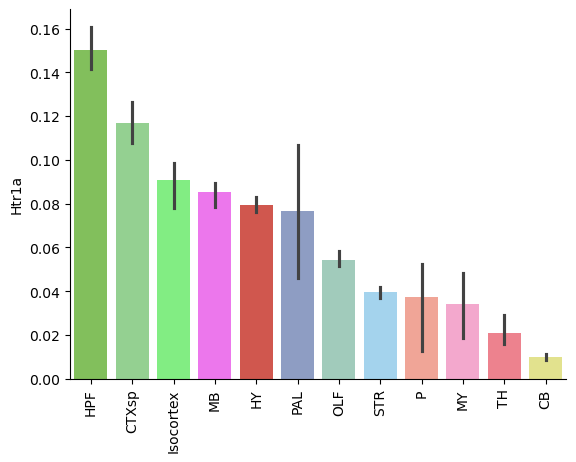

In [35]:
filtered_data = data[data['parcellation_category'] == "grey"].groupby(['parcellation_division', 'feature_matrix_label'])[gene].mean().reset_index()
sorted_divisions = (filtered_data.groupby('parcellation_division')[gene]
                    .mean()
                    .sort_values(ascending=False)
                    .index)

ax = sns.barplot(data=filtered_data, x='parcellation_division', hue='parcellation_division', y=gene, palette=color_dict, order=sorted_divisions )
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('')
sns.despine()

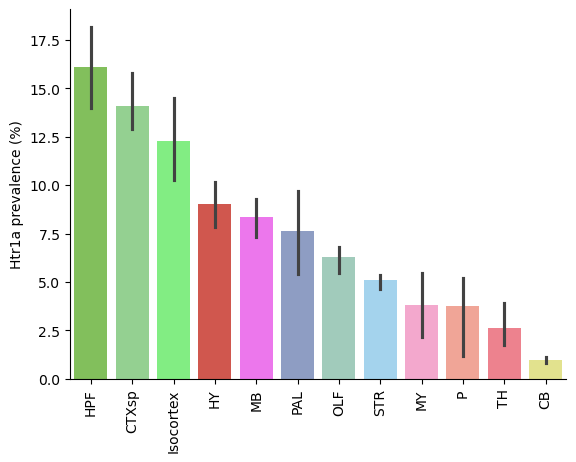

In [37]:
filtered_data = data[data['parcellation_category'] == "grey"].groupby(['parcellation_division', 'feature_matrix_label'])[gene].apply(percentage_non_zero).rename(f"{gene} prevalence (%)").reset_index()
sorted_divisions = (filtered_data.groupby('parcellation_division')[f"{gene} prevalence (%)"]
                    .mean()
                    .sort_values(ascending=False)
                    .index)
ax = sns.barplot(data=filtered_data, x='parcellation_division', hue='parcellation_division', y=f"{gene} prevalence (%)", palette=color_dict, order=sorted_divisions)
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('')
sns.despine()

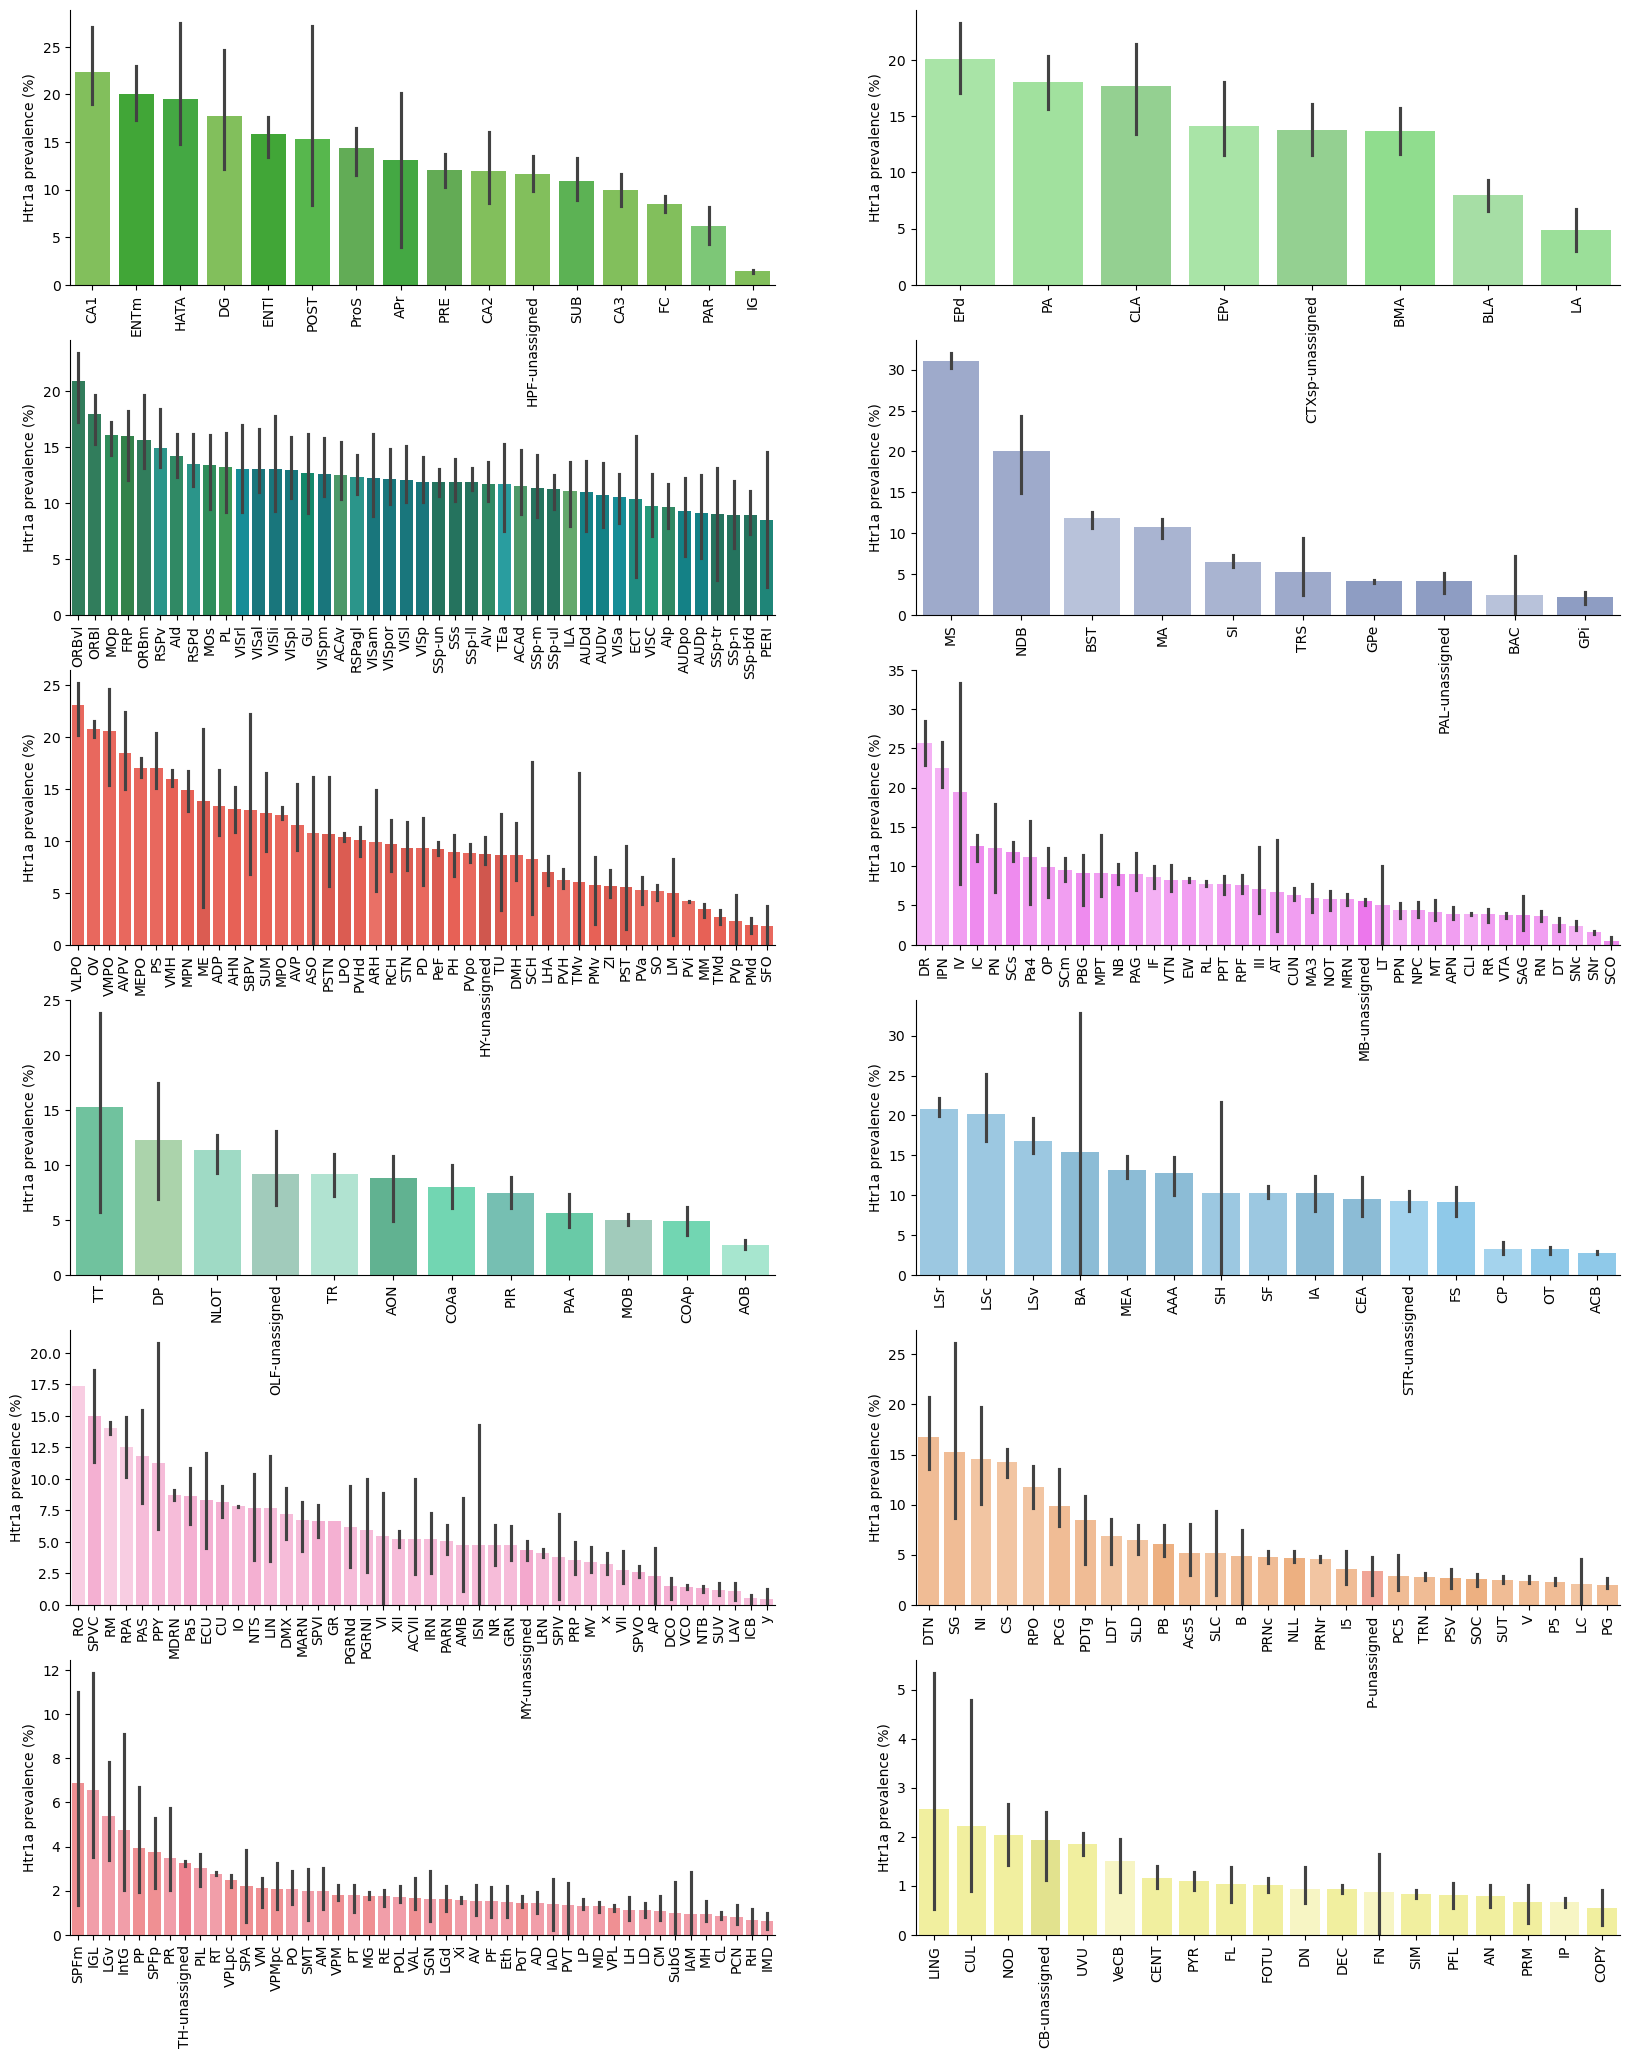

In [39]:
fig, axs = plt.subplots(6,2, figsize=(20, 25))
for ax, p in zip(axs.ravel(), data[data['parcellation_category'] == "grey"].groupby(['parcellation_division'])[gene].apply(percentage_non_zero).sort_values(ascending=False).reset_index()["parcellation_division"]):
    
    filtered_data = data[data['parcellation_division'] == p].groupby(['parcellation_structure', 'feature_matrix_label'])[gene].apply(percentage_non_zero).rename(f"{gene} prevalence (%)").reset_index()
    sorted_divisions = (filtered_data.groupby('parcellation_structure')[f"{gene} prevalence (%)"]
                    .mean()
                    .sort_values(ascending=False)
                    .index)
    sns.barplot(data=filtered_data, x='parcellation_structure', hue='parcellation_structure', y=f"{gene} prevalence (%)", palette=color_dict, ax=ax, order=sorted_divisions)
    ax.tick_params(axis='x', rotation=90)
    ax.set_facecolor('none')
    ax.set_xlabel('')
sns.despine()

In [39]:
from matplotlib import gridspec

In [50]:
gene = "Htr1a"

In [73]:

def plot_slice(ax, section):
    ax.scatter(section["x"],section["y"],s=0.5, c=section[gene],marker='.',cmap=sns.color_palette("rocket_r", as_cmap=True))
    ax.scatter(-section["x"]+12,section["y"],s=0.5, c=section['parcellation_structure_color'],marker='.')
    ax.set_ylim(11,0)
    ax.set_xlim(0,11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])


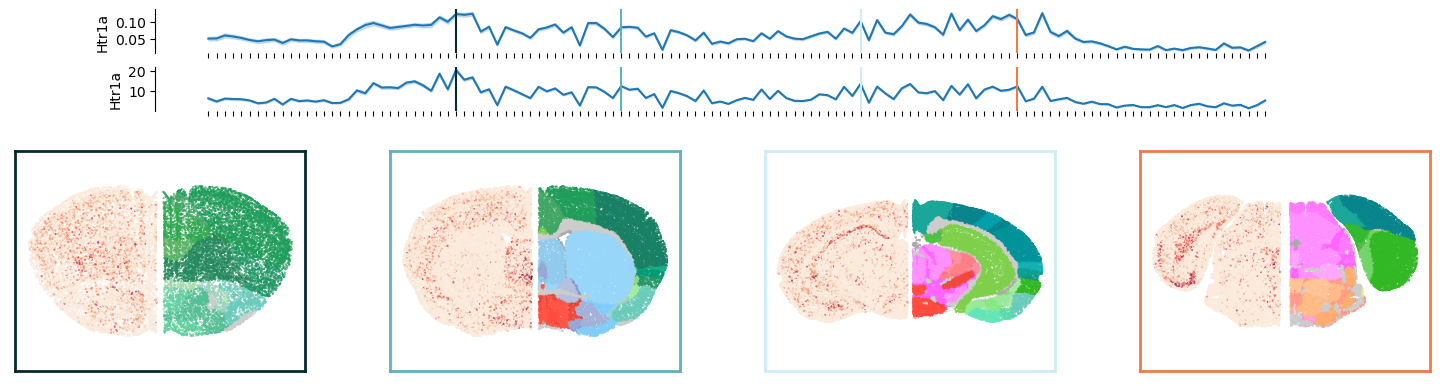

In [75]:
# Your setup code remains the same...
fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(3, 4, height_ratios=[.2, .2, 1])
subfig = fig.add_subfigure(gs[0,:])
ax = subfig.subplots()

data = cell_expression[datasets[0]].sort_values(by='brain_section_label')
data = data[data['parcellation_division'] != "unassigned"]
# Choose colors for each section

dataset = 'Zhuang-ABCA-1'

s = data.groupby('brain_section_label')[gene].apply(percentage_non_zero)

# Find the peaks that are at least 20 distance apart
peaks, _ = find_peaks(s, distance=15)

# Extract these peak values from the series
peak_values = s.iloc[peaks].nlargest(4).sort_index()

section_colors = {
    peak_values.index[0]: '#042A2B',
    peak_values.index[1]: '#5EB1BF',
    peak_values.index[2]: '#CDEDF6',
    peak_values.index[3]: '#EF7B45'
}


sns.lineplot(data=data, x='brain_section_label', y=gene, ax=ax)

# Add colored vertical lines to the top plot
for section, color in section_colors.items():
    ax.axvline(x=section, color=color)
sns.despine(ax=ax, bottom=True)

subfig = fig.add_subfigure(gs[1,:])
ax = subfig.subplots()
sns.lineplot(data=data, x='brain_section_label', y=gene, ax=ax, estimator=percentage_non_zero)

for section, color in section_colors.items():
    ax.axvline(x=section, color=color)
sns.despine(ax=ax, bottom=True)

sections = list(section_colors.keys())

# Below plots
for i in range(len(section_colors)):
    subfig = fig.add_subfigure(gs[2,i])
    ax = subfig.subplots()
    section = data[data['brain_section_label'] == sections[i]]
    
    plot_slice(ax, section)
    # Set the border color of the subplot
    for spine in ax.spines.values():
        spine.set_edgecolor(section_colors[sections[i]])
        spine.set_linewidth(2)  # adjust the width of the border as needed



# Interactive

In [22]:
import panel as pn
import holoviews as hv
from holoviews import dim, opts

pn.extension()

In [36]:
# Create a sorted list of unique section names

dataset_changed = pn.widgets.Checkbox(name='Dataset Changed', value=False)


dataset_selector = pn.widgets.Select(name='Dataset Selector', options=datasets, value=datasets[0])

dataset = datasets[0]

section_names = sorted(cell_expression[dataset]['brain_section_label'].unique())

section_name_display = pn.pane.HTML()

# Create a slider for selecting brain sections based on the length of the section_names list
slider = pn.widgets.IntSlider(name='Brain Section Index', start=0, end=len(section_names) - 1, value=0)

gene_selector = pn.widgets.Select(name='Gene Selector', options=htrgenes.tolist(), value=htrgenes[0])


@pn.depends(dataset_selector.param.value, watch=True)
def on_dataset_change(selected_dataset):
    #print(f"Dataset changed to: {selected_dataset}") # Debugging print
    section_names = get_section_names(selected_dataset)
    slider.end = len(section_names) - 1
    #print(f"Slider end set to: {slider.end}") # Debugging print
    slider.param.set_param(value=0)
    #print(f"Slider value set to: {slider.value}") # Debugging print
    dataset_changed.value = True


def get_section_names(dataset):
    return sorted(cell_expression[dataset]['brain_section_label'].unique())

@pn.depends(dataset_selector.param.value, watch=True)
def update_slider_range(selected_dataset):
    section_names = get_section_names(selected_dataset)
    slider.end = len(section_names) - 1


@pn.depends(slider.param.value, dataset_selector.param.value, watch=True)
def update_section_name_display(section_index, dataset=dataset_selector.value):
    section_names = get_section_names(dataset)
    brain_section = section_names[section_index]
    section_name_display.object = f"<b>Brain Section:</b> {brain_section}"


@pn.depends(slider.param.value_throttled, gene_selector.param.value, dataset_selector.param.value)
def plot_expr_across_slices(section_index, gene, dataset):
    
    curve_data = cell_expression[dataset].groupby('brain_section_label')[gene].mean()
    curve_data.rename(f"Expression {gene}", inplace=True)
    curve = hv.Curve(curve_data, label='Gene Expression').opts(xaxis=None, width=1000, height=100, active_tools=[])
    
    grouped_data = cell_expression[dataset].groupby('brain_section_label')[gene].apply(percentage_non_zero).reset_index()
    grouped_data.rename(columns={gene:"%"}, inplace=True)
    percentage_curve = hv.Curve(grouped_data, 'brain_section_label', "%", label='Percentage Non-Zero').opts(xaxis=None, width=1000, height=100, active_tools=[])
    
    vline = hv.VLine(section_index).opts(line_color='red', line_width=2)
    
    return hv.Layout([(curve * vline), (percentage_curve * vline)]).cols(1)
    
@pn.depends(slider.param.value_throttled, gene_selector.param.value, dataset_selector.param.value)
def plot_section(section_index, gene, dataset):
    section_names = get_section_names(dataset)  
    # Check if the dataset has changed and reset the flag
    
    if dataset_changed.value:
        section_index = 0
        dataset_changed.value = False

    if section_index >= len(section_names):
        section_index = len(section_names) - 1  # Set to the last valid index
        
    brain_section = section_names[section_index]
    section = cell_expression[dataset][cell_expression[dataset]['brain_section_label'] == brain_section]
    section = section[section['parcellation_division'] != "unassigned"]

    plot1 = hv.Points(data=section, kdims=['x', 'y' ], vdims=[gene,'parcellation_structure', 'parcellation_substructure']).opts(width=550,colorbar=True, cmap='rocket_r', size=2, color=gene)
    plot2 = hv.NdOverlay({division: hv.Points(section[section['parcellation_division'] == division], ['x', 'y'], ['parcellation_division_color','parcellation_structure', 'parcellation_substructure']).opts(color='parcellation_division_color', size=2) for division in section[section['parcellation_category'] == "grey"]['parcellation_division'].unique()}, kdims='parcellation_division').opts(legend_position='top_right', width=450,show_legend=True)

    common_opts = opts.Points(height=500,  invert_yaxis=True, xaxis=None, yaxis=None, show_grid=False, active_tools=[], tools=["hover"])

    return (plot1 + plot2).opts(common_opts)

@pn.depends(slider.param.value_throttled, gene_selector.param.value, dataset_selector.param.value)
def plot_bar(section_index, gene, dataset):
    section_names = get_section_names(dataset)
    
    if dataset_changed.value:
        section_index = 0
        dataset_changed.value = False
        
    brain_section = section_names[section_index]
    section = cell_expression[dataset][cell_expression[dataset]['brain_section_label'] == brain_section]
    section = section[section['parcellation_division'] != "unassigned"]
    color_map = section.groupby('parcellation_structure')['parcellation_structure_color'].first().to_dict()

    hv_ds = hv.Dataset(section.groupby(['parcellation_structure'])[gene].apply(percentage_non_zero).sort_values(ascending=False).head(20).reset_index(), 
                       kdims=['parcellation_structure'], vdims=[gene])
    
    # Create the vertical Bar chart with rotated xticklabels
    bar_plot = hv.Bars(hv_ds).opts(
        color=dim('parcellation_structure').categorize(color_map, 'gray'),
        active_tools=[],
        tools=["hover"],
        frame_width=800,
        frame_height=100,
        invert_axes=False,
        xrotation=90  # Rotate xticklabels by 90 degrees
    )
    return bar_plot
# Update inter to use the combined_plot function

pn.Column(pn.Row(gene_selector, dataset_selector, slider, section_name_display) , pn.Row(plot_expr_across_slices), plot_bar, plot_section)

Column
    [0] Row
        [0] Select(name='Gene Selector', options=['Htr1a', 'Htr1b', ...], value='Htr1a')
        [1] Select(name='Dataset Selector', options=['Zhuang-ABCA-1', ...], value='Zhuang-ABCA-1')
        [2] IntSlider(end=128, name='Brain Section Index')
        [3] HTML(None)
    [1] Row
        [0] ParamFunction(function, _pane=HoloViews, defer_load=False)
    [2] ParamFunction(function, _pane=HoloViews, defer_load=False)
    [3] ParamFunction(function, _pane=HoloViews, defer_load=False)